In [1]:
from google.colab import drive
drive.mount('/content/drive')


## imports

import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow.keras.models import load_model


Mounted at /content/drive


In [2]:

model = load_model("/content/drive/My Drive/Vayuh_assignment/DeepLearning/model.h5")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 26)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 64)            23296     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [12]:
data = pd.read_csv("/content/drive/My Drive/Vayuh_assignment/dataset/dataset_test_3Yr.csv")
del data["Unnamed: 0"]

print(data.loc[(data["0"] == "2021-01-22") & (data["lat"] == 43.25) &(data["lon"] == 263.75)])
data.head()


                 0         1         2         3  ...   23    lat     lon      tmp2m
106711  2021-01-22  1.821619  0.406205  1.892088  ... -0.8  43.25  263.75 -19.782063

[1 rows x 27 columns]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,lat,lon,tmp2m
0,2019-07-01,2.573991,-1.577450,-0.592047,0.940447,-0.261662,0.460954,-0.383782,0.517393,-0.557463,0.588692,0.503463,-0.074946,-0.373403,0.193848,-0.594850,0.24,-0.663,8,0.845146,0.3,0.1,0.2,-0.4,27.25,261.75,30.366022
1,2019-07-02,2.653952,-1.595283,-0.599098,1.005032,-0.130263,0.517365,-0.379773,1.161723,-0.315278,0.510653,0.403254,0.259522,-0.896581,0.037032,-0.508564,0.24,-0.620,8,0.613389,0.3,0.1,0.2,-0.4,27.25,261.75,30.265896
2,2019-07-03,2.673004,-1.513088,-0.482026,1.086232,-0.148308,0.523015,-0.095524,1.224866,-0.208681,0.448946,0.373341,0.851259,-0.190742,0.953511,0.119690,0.24,-0.706,1,1.103147,0.0,0.7,0.5,-0.4,27.25,261.75,30.267775
3,2019-07-04,2.770815,-1.461444,-0.418628,1.178878,-0.153201,0.677923,0.018825,1.130869,-0.197772,0.538704,0.657843,1.130562,-0.232851,1.446056,0.379550,0.24,-0.664,1,1.405462,0.0,0.7,0.5,-0.4,27.25,261.75,30.162596
4,2019-07-05,2.706619,-1.472493,-0.373457,1.149119,-0.209551,0.907009,-0.240610,1.204198,0.143567,0.163814,0.587062,0.771353,-0.697190,0.867796,0.103741,0.24,-0.749,1,1.628860,0.0,0.7,0.5,-0.4,27.25,261.75,30.097599


In [4]:
features_final = ['tmp2m','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 'lat',
       'lon']
train_mean = pd.read_csv("/content/drive/My Drive/Vayuh_assignment/DeepLearning/train_mean.csv",index_col= 0)
train_std = pd.read_csv("/content/drive/My Drive/Vayuh_assignment/DeepLearning/train_std.csv",index_col = 0)
lag = 14
# Steps ahead to forecast 
n_ahead = 1
test_share = 0.1


In [5]:
"""
A method to create X and Y matrix from a time series array for the training of 
deep learning models 

The lag I have taken is 14 days, so the temp prediction done on day X will have previous 13 values + X's values to predict Y (Avg temp over 2 weeks, 2 weeks from X)   

"""
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            # print(Y)
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [6]:
data_train = pd.read_csv("/content/drive/My Drive/Vayuh_assignment/dataset/dataset_training_15Yr.csv")
data_train.head()

# Subseting only the needed columns 
ts = data_train[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1- test_share))]

# Scaling the data 
test_mean = train.mean()
test_std = train.std()


In [7]:
# Subseting only the needed columns 
test_val = data[features_final]
test_3 = (test_val - test_mean)/ test_std
ts_s = pd.concat([test_3])
# # Creating the X and Y for training
X_test, Y_test = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)



In [8]:
print(X_test.shape)
print(Y_test.shape)


(144189, 14, 26)
(144189, 1)


**Predictions**

In [9]:

########################### PREDICTING #########################################

yhat = [x[0] for x in model.predict(X_test)]
yhat_np = model.predict(X_test)
y = [y[0] for y in Y_test]


In [ ]:
len(y)

144189

In [18]:
############$################### Creating a CSV  to store both predictions ####################


days = data['0'].values[-len(y):]
lat = data['lat'].values[-len(y):]
lon = data['lon'].values[-len(y):]

results_csv = pd.DataFrame({'day': days, 'lat': lat, 'lon': lon, 'temp_original': y, 'temp_forecast': yhat})
results_csv['temp_absolute_original'] = [(x * test_std['tmp2m']) + test_mean['tmp2m'] for x in frame_test['temp_original']]
results_csv['temp_absolute_forecast'] = [(x * test_std['tmp2m']) + test_mean['tmp2m'] for x in frame_test['temp_forecast']]

results_csv.to_csv("/content/drive/My Drive/Vayuh_assignment/DeepLearning/result_temperature_forecast.csv")
   


In [ ]:
import math
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, yhat)
rmse = math.sqrt(mse)
print("Scaled value rmse: ",rmse)


inverse_y = Y_test*test_std["tmp2m"] + test_mean["tmp2m"]
inverse_yhat = yhat_np*test_std["tmp2m"] + test_mean["tmp2m"]
yhat_in = [x[0] for x in inverse_yhat]
y_in = [y[0] for y in inverse_y]


mse_inv = mean_squared_error(y_in, yhat_in)
rmse_inv = math.sqrt(mse_inv)
print("Actual value rmse: ",rmse_inv)

Scaled value rmse:  0.10067762838387022
Actual value rmse:  1.0323063695350512


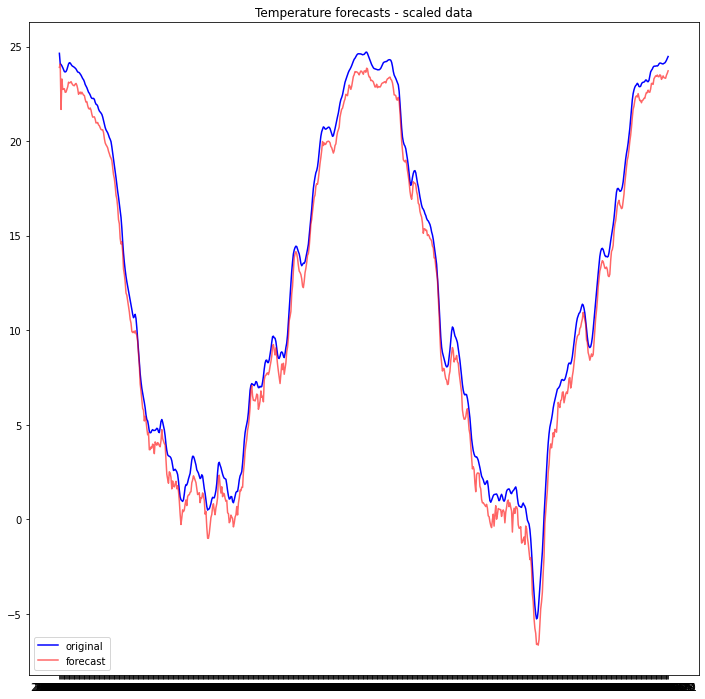

In [17]:

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * test_std['tmp2m']) + test_mean['tmp2m'] for x in frame['temp']]

# Pivoting

# Pivoting
pivoted_test = frame.pivot_table(index='day', columns='type')
pivoted_test.columns = ['_'.join(x).strip() for x in pivoted_test.columns.values]
pivoted_test['res'] = pivoted_test['temp_absolute_original'] - pivoted_test['temp_absolute_forecast']
pivoted_test['res_abs'] = [abs(x) for x in pivoted_test['res']]
plt.figure(figsize=(12, 12))
plt.plot(pivoted_test.index, pivoted_test.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted_test.index, pivoted_test.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)

plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()